Let's look at some iron ore data

C:\Users\tdavies\AppData\Local\conda\conda\envs\CORE_Week_01\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\tdavies\AppData\Local\conda\conda\envs\CORE_Week_01\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\tdavies\AppData\Local\conda\conda\envs\CORE_Week_01\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\tdavies\AppData\Local\conda\conda\envs\CORE_Week_01\lib\site-packages\numpy\core\fromnumeric.py:83

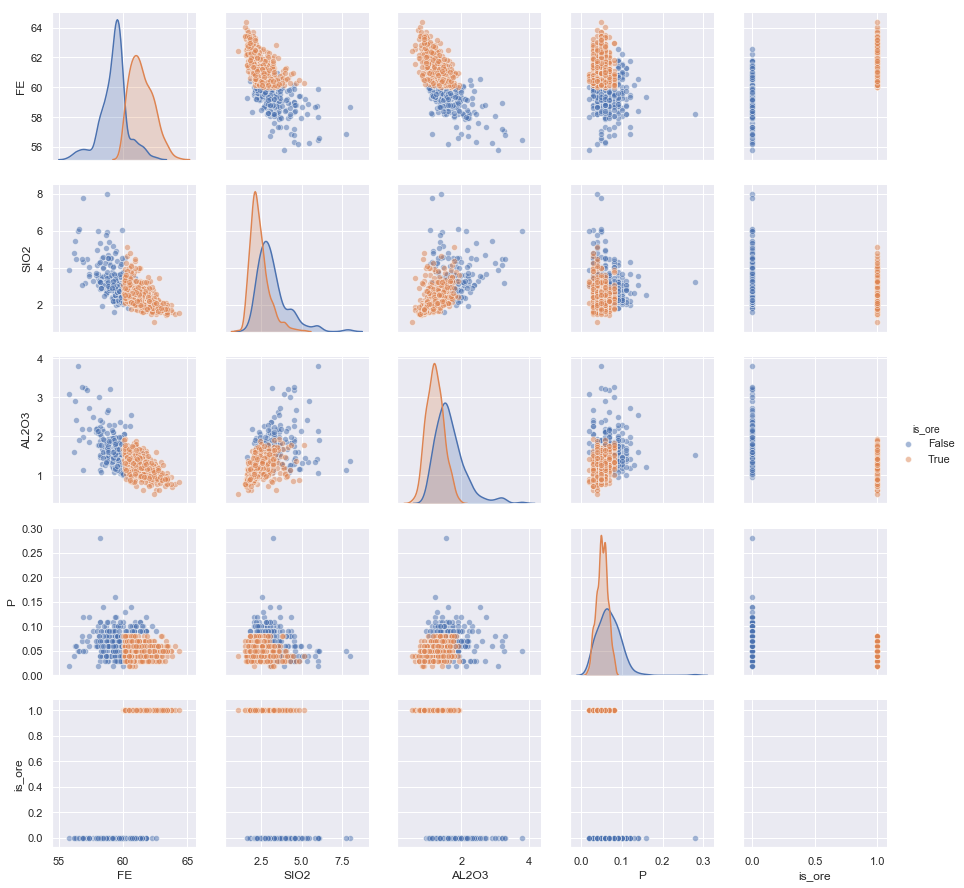

In [88]:
import pandas
import seaborn
import matplotlib.pyplot as plt
import os
import numpy as np
seaborn.set()

df = pandas.read_csv(os.path.abspath('iron_ore_study.csv'))

# Splits from oscar Fe>60%, SiO2<9, Al2O3<2, P<0.08
split_points = [
    ('FE', 60, [False, True]),
    ('SIO2', 9, [True, False]),
    ('AL2O3', 2, [True, False]),
    ('P', 0.08, [True, False]),  
]

# It's ore if everything is True
df['is_ore'] = np.vstack([
    pandas.cut(df[elem], bins=[0, split, 100], labels=is_ore)
    for elem, split, is_ore in split_points
]).sum(axis=0) == 4

# Take a look
seaborn.pairplot(df.iloc[::5], hue='is_ore', plot_kws={'alpha': 0.5})

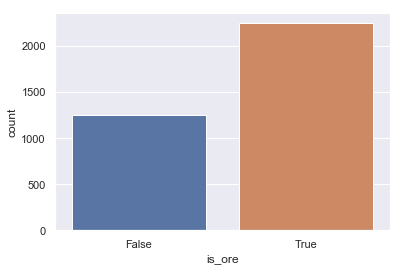

In [89]:
seaborn.countplot('is_ore', data=df)

Plot our x data

C:\Users\tdavies\AppData\Local\conda\conda\envs\CORE_Week_01\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


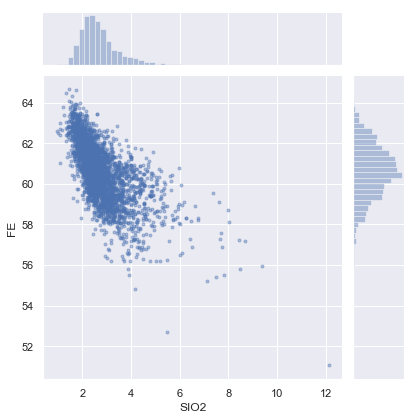

In [90]:
seaborn.jointplot('SIO2', 'FE', df, joint_kws={'alpha': 0.4, 'marker': '.'})

C:\Users\tdavies\AppData\Local\conda\conda\envs\CORE_Week_01\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


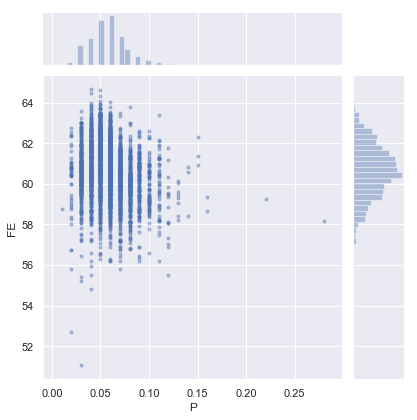

In [91]:
seaborn.jointplot('P', 'FE', df, joint_kws={'alpha': 0.4, 'marker': '.'})

## Logistic regression

You can think of the logistic function as a function that takes a real number (as comes out of the linear regression) and 'squashes' it into a 0, 1 label. It's defined as

$$
g(z) = \frac{1}{1 + e^{-z}}
$$

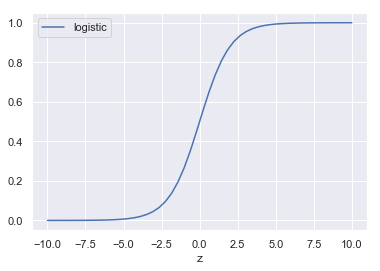

In [92]:
def logistic(z):    
    return 1 / (1 + np.exp(-z))

zs = np.linspace(-10, 10)
logistic_data = pandas.DataFrame( 
    {'z': zs, 'logistic': logistic(zs)}
)
logistic_data.plot('z', 'logistic')

If we can generate a linear model fit with one parameter - call it $f$:

$$
z = f(x) = a + b x
$$

where $a$ is the intercept, $b$ the coefficient and $x$ is the input features. Then we get label predictions

$$
\mathrm{label} = g(f(x)) > threshold
$$

## Problem

Let's pretend we have a crappy sensor which only measures Al. Can we still make good predictions of ore/not ore using just this feature?

We should look at transforming our aluminium data so that we go from (0, inf) -> (-inf, inf). We'll do this in a hacky sense by using a log function but we should really use a log-ratio transform here!

C:\Users\tdavies\AppData\Local\conda\conda\envs\CORE_Week_01\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


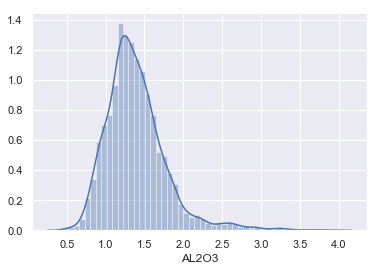

In [93]:
seaborn.distplot(df['AL2O3'])

C:\Users\tdavies\AppData\Local\conda\conda\envs\CORE_Week_01\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


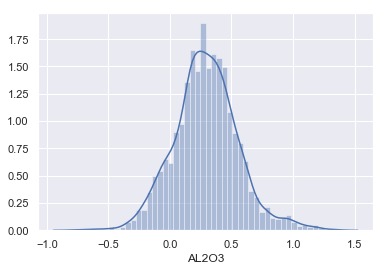

In [94]:
seaborn.distplot(np.log(df['AL2O3']))

We'll do this using a scikit-learn pipeline - this lets us chain transformations and predictions into one object which makes life a lot easier.

In [95]:
from sklearn import preprocessing, pipeline, linear_model

# Make up our pipeline where we transform the aluminium first to make it more gaussian!
regressor = pipeline.Pipeline([
    ('transform', preprocessing.FunctionTransformer(np.log, validate=True)),
    ('model', linear_model.LogisticRegression())
])

Next we map the data into the `y ~ f(X)` format that scikit-learn wants

In [102]:
X = df[['AL2O3']]
y = df['is_ore']

Now fitting the model is as simple as

In [103]:
regressor.fit(X, y)

Pipeline(memory=None,
     steps=[('transform', FunctionTransformer(accept_sparse=False, func=<ufunc 'log'>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=True)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

Once we've fitted the model we can make predictions straight away

In [104]:
predict_df = pandas.DataFrame(
    {'test_al2o3_values': [0.5, 1, 2, 3, 4]} # Are these values ore?
)  
regressor.predict(predict_df)

array([ True,  True, False, False, False])

To see what's going on in a bit more depth, we can pull the coefficients out of the scikit-learn pipeline

In [105]:
model = regressor.named_steps.model
model.intercept_, model.coef_

(array([2.46029206]), array([[-5.72109219]]))

and rewrite our logistic function to include the linear model

In [106]:
def logistic(regressor, X):
    """
    Plot our logistic model given input values x
    
    We're doing this so that we can see the output of the logistic function - normally
    you'd just do `regressor.predict(x)` to get actual 1, 0 labels for your data.
    
    Parameters:
        regressor - a fitted logistic regression pipeline
        x - the values to evaulate the function at
    """
    # We can pull the model and transforms from our pipeline
    model = regressor.named_steps.model
    tf = regressor.named_steps.transform
    
    # Next we replay the steps in the pipeline to make a prediction
    z = model.intercept_ + model.coef_[0][0] * tf.transform(X)
    return 1 / (1 + np.exp(-z)).ravel()

Now we can evaulate our logistic function for our test values

In [107]:
logistic(regressor, predict_df)

array([0.99838346, 0.92131084, 0.1816413 , 0.02135318, 0.00419012])

With these in hand lets generate some plots

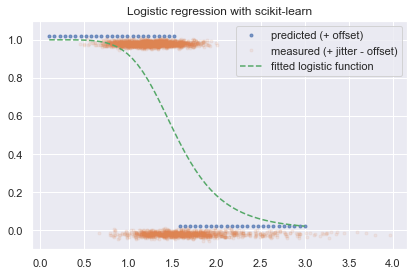

In [109]:
f, ax = plt.subplots(1, 1)

# Some aluminium values to predict from
al_compositions = pandas.DataFrame(
    {'test_al2o3_values': np.linspace(0.1, 3)}
)

# An offset to stop everything plotting on top of everything else
offset = 0.02

# shows predictions given contents
predictions = regressor.predict(al_compositions)
ax.plot(al_compositions, predictions + offset, '.', alpha=0.7, label='predicted (+ offset)')  

# shows measured values plus jitter
jitter = np.random.normal(scale=0.01, size=len(df))
ax.plot(df['AL2O3'], df['is_ore'] + jitter - offset, '.', alpha=0.1, label='measured (+ jitter - offset)')

# shows logistic function fitted from regressor
ax.plot(al_compositions, logistic(regressor, al_compositions), '--', label='fitted logistic function')

# Generate the logistic curve showing the location of 
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.set_title('Logistic regression with scikit-learn')
f.tight_layout()
#plot below: where y axis = 0.5 move across to logistic function. this shows hte cut off between is_ore and not is_ore.

Try this using one of the other variables!

## Measuring model performance

We don't get everything right! How can we get a feeling for the model performance? What are some of the issues that we might need to take into account?

In [20]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.33)

Now we can train on just the training set, predict on the test set and see how we do!

In [21]:
regressor.fit(X_train, y_train)


Pipeline(memory=None,
     steps=[('transform', FunctionTransformer(accept_sparse=False, func=<ufunc 'log'>, inv_kw_args=None,
          inverse_func=None, kw_args=None, pass_y='deprecated',
          validate=True)), ('model', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [22]:
y_predict = regressor.predict(X_test)

In [23]:
results = pandas.DataFrame({
    'AL2O3': X_test['AL2O3'],
    'is_ore_actual': y_test,
    'is_ore_predicted': y_predict,
    'count': 1
})
results.head()

,AL2O3,is_ore_actual,is_ore_predicted,count
3039,1.29,True,True,1
826,1.28,True,True,1
2025,1.23,True,True,1
2617,1.41,False,True,1
1781,1.33,True,True,1


Now we can see the number of false positives and false negatives using pivot_table from last week

In [24]:
confusion = results.pivot_table(values='count', index='is_ore_actual', columns='is_ore_predicted', aggfunc='sum')
confusion

is_ore_predicted,False,True
is_ore_actual,,
False,243,186
True,85,641


and plot with seaborn

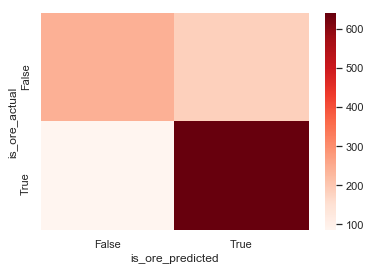

In [25]:
seaborn.heatmap(confusion, cmap='Reds')

Alternatively we can unstack the array into true and false negatives and positives

In [26]:
confusion.unstack()

is_ore_predicted  is_ore_actual
False             False            243
                  True              85
True              False            186
                  True             641
dtype: int64

And we can convert these values to fractions of the total

In [27]:
true_neg, false_neg, true_pos, false_pos = confusion.unstack() / confusion.unstack().sum()
true_neg, false_neg, true_pos, false_pos

(0.21038961038961038,
 0.0735930735930736,
 0.16103896103896104,
 0.554978354978355)

When are true positives and false positives important?

## Threshold

We haven't done anything with the threshold yet - how should we pick the value for this?

We've already got a confusion matrix - we can take the ratio of the true_positive vs the false_positive rates and compare the two 

In [28]:
confusion

is_ore_predicted,False,True
is_ore_actual,,
False,243,186
True,85,641


In [29]:
correct = np.diag(confusion)
incorrect = np.diag(np.roll(confusion, 1, axis=1))
correct, incorrect

(array([243, 641], dtype=int64), array([186,  85], dtype=int64))

In [30]:
total_correct = correct.sum()
total_incorrect = incorrect.sum()
total_correct, total_incorrect

(884, 271)

And we can plot this for each threshold. We need a way of adjusting the class weights in the model. Scikit-learn doesn't let you specify a threshold directly but 

In [31]:
def fit_with_class_threshold(threshold):
    "Fit a logistic regression to get an ROC value for a given threshold"
    # Transform our threshold into class weights
    class_weights = {True: threshold, False: 1 - threshold}
    
    # Make a regressor
    regressor = pipeline.Pipeline([
        ('transform', preprocessing.FunctionTransformer(np.log, validate=True)),
        ('model', linear_model.LogisticRegression(class_weight=class_weights))
    ])
    
    # Fit it
    regressor.fit(X_train, y_train)
    
    # Make some predictions, see how we did
    results = pandas.DataFrame({
        'AL2O3': X_test['AL2O3'],
        'is_ore_actual': y_test,
        'is_ore_predicted': regressor.predict(X_test),
        'count': 1
    })
    confusion = results.pivot_table(
        values='count', 
        index='is_ore_actual', 
        columns='is_ore_predicted', 
        aggfunc='sum')
    true_neg, false_neg, true_pos, false_pos = confusion.unstack()
    correct = np.diag(confusion)
    incorrect = np.diag(np.roll(confusion, 1, axis=1))
    
    # Return results as a dictionary
    return {
        'threshold': threshold,
        'total_correct': correct.sum(), 
        'total_incorrect': incorrect.sum(), 
        'true_negative': true_neg,
        'false_negative': false_neg,
        'true_positive': true_pos,
        'false_positive': false_pos
    }

Now we can generate results using our metric

In [32]:
fit_with_class_threshold(0.1)

{'threshold': 0.1,
 'total_correct': 527,
 'total_incorrect': 628,
 'true_negative': 425,
 'false_negative': 624,
 'true_positive': 4,
 'false_positive': 102}

In [33]:
fit_with_class_threshold(0.9)

{'threshold': 0.9,
 'total_correct': 755.0,
 'total_incorrect': nan,
 'true_negative': 29.0,
 'false_negative': nan,
 'true_positive': 400.0,
 'false_positive': 726.0}

Now we can iterate over all our thresholds and see what does the best

In [34]:
results = pandas.DataFrame.from_records(
    [fit_with_class_threshold(t) for t in np.linspace(0.1, 0.9)],
    index='threshold'
)
results.head()

,false_negative,false_positive,total_correct,total_incorrect,true_negative,true_positive
threshold,,,,,,
0.100000,624.0,102.0,527.0,628.0,425.0,4.0
0.116327,590.0,136.0,559.0,596.0,423.0,6.0
0.132653,565.0,161.0,583.0,572.0,422.0,7.0
0.148980,534.0,192.0,608.0,547.0,416.0,13.0
0.165306,514.0,212.0,626.0,529.0,414.0,15.0


We'll generate a few plots 

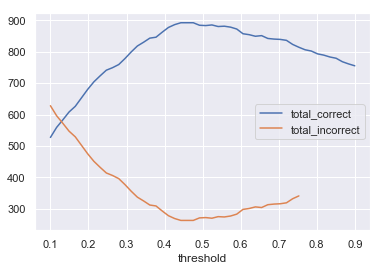

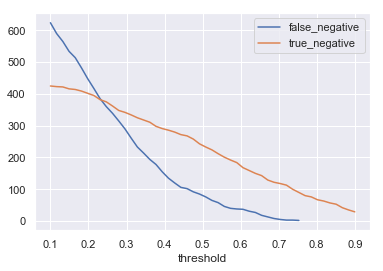

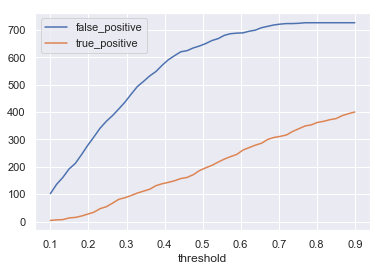

In [35]:
results.plot(y=['total_correct', 'total_incorrect'])
results.plot(y=['false_negative', 'true_negative'])
results.plot(y=['false_positive', 'true_positive'])

## Extension - modelling with statsmodels

For what it's worth we can also generate these using statsmodels

In [36]:
import statsmodels.api as sm
from numpy import log

We have to handle preprocessing ourselves 

In [37]:
from statsmodels.tools import add_constant

def preprocess(x):
    "Our preprocessing pipeline for Al2O3"
    return add_constant(np.log(x)) # add_constant adds an intercept to the fit

Statsmodels uses stats jargon 
- endog -> endogenous variable -> y
- exog -> exogenous variable -> X

In [38]:
endog = df.is_ore
exog = preprocess(df['AL2O3'])

Fitting the model is pretty similar though

In [115]:
model = sm.Logit(endog, exog)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.492165
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 is_ore   No. Observations:                 3500
Model:                          Logit   Df Residuals:                     3498
Method:                           MLE   Df Model:                            1
Date:                Tue, 02 Oct 2018   Pseudo R-squ.:                  0.2453
Time:                        14:44:25   Log-Likelihood:                -1722.6
converged:                       True   LL-Null:                       -2282.3
                                        LLR p-value:                1.922e-245
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5869      0.092     27.996      0.000       2.406       2.768
AL2O3         -6.0717      0.236    -25.774      0.000      -6.533      -5.610
==============================================================================
"""

Statsmodels does a bit more statistical testing/automated confidence intervals for us at the cost of having to manage crossvalidation etc ourselves. Depending on what you're trying to achieve this could be a viable way to go.

As before we can immediately make some predictions - statsmodels gives us the value of the logistic function

In [116]:
al_compositions = pandas.DataFrame(
    {'test_al2o3_values': np.linspace(0.1, 3)}
)

In [118]:
preds = model.predict(results.params, preprocess(al_compositions))
preds

array([0.99999994, 0.99999893, 0.99999268, 0.99996862, 0.99989853,
       0.99972884, 0.99936843, 0.99867413, 0.99743442, 0.99535199,
       0.99202694, 0.9869432 , 0.97946242, 0.96883132, 0.9542096 ,
       0.9347258 , 0.90956546, 0.87808926, 0.83996729, 0.79530294,
       0.74471098, 0.68931693, 0.63066273, 0.57053221, 0.51073669,
       0.45291267, 0.39837465, 0.34804342, 0.30244575, 0.2617652 ,
       0.22591905, 0.19464021, 0.16755039, 0.14421809, 0.12420033,
       0.10706998, 0.09243181, 0.07993036, 0.06925228, 0.06012534,
       0.05231545, 0.04562286, 0.03987792, 0.03493711, 0.03067926,
       0.02700217, 0.0238197 , 0.02105919, 0.01865936, 0.01656841])

In [119]:
preds > 0.5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

and compare to scikit-learn

In [121]:
regressor.predict(al_compositions)

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False])

We can also compare the logistic values get slightly different answers here - probably down to the solver used under the hood

In [122]:
print(' statsmodels:', model.predict(results.params, preprocess(al_compositions)))
print('scikit-learn:', logistic(regressor, al_compositions))

 statsmodels: [0.99999994 0.99999893 0.99999268 0.99996862 0.99989853 0.99972884
 0.99936843 0.99867413 0.99743442 0.99535199 0.99202694 0.9869432
 0.97946242 0.96883132 0.9542096  0.9347258  0.90956546 0.87808926
 0.83996729 0.79530294 0.74471098 0.68931693 0.63066273 0.57053221
 0.51073669 0.45291267 0.39837465 0.34804342 0.30244575 0.2617652
 0.22591905 0.19464021 0.16755039 0.14421809 0.12420033 0.10706998
 0.09243181 0.07993036 0.06925228 0.06012534 0.05231545 0.04562286
 0.03987792 0.03493711 0.03067926 0.02700217 0.0238197  0.02105919
 0.01865936 0.01656841]
scikit-learn: [0.99999984 0.99999768 0.99998584 0.99994418 0.99983134 0.99957422
 0.99905571 0.9981013  0.99646503 0.99381607 0.98972764 0.98367133
 0.97502055 0.96306818 0.94706338 0.92627155 0.90005744 0.86798504
 0.8299196  0.78610953 0.73722352 0.68432434 0.62877606 0.57210045
 0.51581361 0.46127781 0.40959556 0.36155788 0.3176429  0.27805145
 0.24276264 0.21159503 0.18426322 0.16042458 0.13971463 0.1217717
 0.10625264 0

We can generate the same plot again though

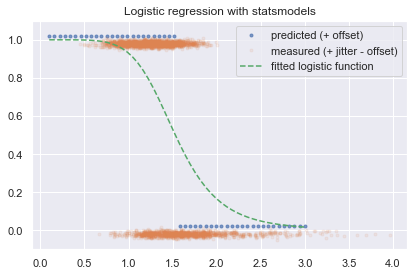

In [123]:
f, ax = plt.subplots(1, 1)

# Some aluminium values to predict from
al_compositions = np.linspace(0.1, 3)

# An offset to stop everything plotting on top of everything else
offset = 0.02

# shows predictions given contents
predictions = model.predict(results.params, preprocess(al_compositions)) > 0.5
ax.plot(al_compositions, predictions + offset, '.', alpha=0.7, label='predicted (+ offset)')  

# shows measured values plus jitter
jitter = np.random.normal(scale=0.01, size=len(df))
ax.plot(df['AL2O3'], df['is_ore'] + jitter - offset, '.', alpha=0.1, label='measured (+ jitter - offset)')

# shows logistic function fitted from regressor
ax.plot(al_compositions, model.predict(results.params, preprocess(al_compositions)), '--', label='fitted logistic function')

# Generate the logistic curve showing the location of 
ax.set_ylim(-0.1, 1.1)
ax.legend()
ax.set_title('Logistic regression with statsmodels')
f.tight_layout()